# Applied Data Science Capstone: A Peek into Cologne's Bars and Restaurants Scene

For the last couple of months I've been taking a series of courses in the field of Data Analysis and one of them is the IBM Data Science professional certificate, provided by Coursera. The final task of the Capstone Project is to apply Data Science for a business problem while leveraging the use of geolocation data out of Foursquare API in combination with the methods and algorithms learned throughout the course. I've chosen to analyze data from Cologne, Germany, the city I've been living for the past 5 years.

### 1. Introduction and Business Problem Statement

Cologne, founded in 38 BC, has a population of more than 1 million people, making it the forth largest city in the country. The city is part of the state of North-Rhine Westfalia, forming together with cities like Düsseldorf, Essen, Bonn, and a couple others, the Rhine-Ruhr area, known as the largest metropolitan region in Germany. It is also located in the far west of the country, having the borders of Belgium and Netherlands within a 100km range and being well-centered in Western Europe.

Home of the Kölner Dom, the tallest twin-spired Church in the world, Cologne is known for its openness and multicultural vibe, with a vibrant nightlife and a variety of options for going out, including bars, clubs and restaurants from all kinds of places in the world. It is home for some of the most relevant and biggest events around, besides being part of a circuit of best music concerts and tours one can find in the region.

This mix of history, entertainment and privileged location makes it a very good destination for tourists and a nice place to live. In this context, investing in the entertainment business in the city is often considered a good option, but then this brings a couple of questions, such as: what kind of establishment makes more sense to be opened? which locations would be best to start such a business? How competitive will be the chosen market? These are some of the questions we propose to answer with this analysis.

#### 1.1 The Problem Statement: Which Cologne neighborhood is the best to start a bar or restaurant?

A client is thinking about investing in opening an establishment in the city of Cologne, so he asked to analyze the available data and cross-reference it against some criteria in order to take a decision. Below further details:

- Two types of establishment were defined as initial targets: a bar or restaurant. It must be one of this two categories, therefore the analysis will prioritize those; 
- It is required that the new establishment is located where there is a good amount of people, preferably not so far away from the city center. In order to have an objective target, it was defined a minimum population density of 3000 people per squared kilometer;
- On the other hand it is important that his establishment has the opportunity to stand out, so a neighborhood with too much competition in the same category should be avoided;
- The place will be rented and the client is willing to pay up to 12€ per squared meter.

#### 1.2 The Target Audience

Besides the obvious interest coming from the aforementioned client in taking a data-driven decision about where to invest his money on, this study can be helpful to a couple of other stakeholders, such as:

- Other investors with a similar interest in investing in the entertainment and gastronomy business in the city of Cologne;
- Fellow Data Scientists that are looking for ideas or references on how to carry out some tasks that might be applicable to their projects, not just for Cologne, but anywhere in the world;
- Cologne Citizens in general, to get further insights on the city they live in and on which neighborhoods there are more options of venues to go and check out.

In [1]:
# Import all the required libraries and modules
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c anaconda lxml --yes
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# library for chart plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # Module from Scikit-learn for Data normalization
from sklearn.cluster import KMeans # Module from Scikit-learn for clustering
from sklearn.datasets.samples_generator import make_blobs
!wget --quiet https://cocl.us/Geospatial_data
!conda install -c conda-forge folium=0.5.0 --yes
import folium
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    libxslt-1.1.33             |       h7d1a2b0_0         577 KB  anaconda
    lxml-4.5.0                 |   py36hefd8a0e_0         1.6 MB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  libxslt            anaconda/linux-64::libxslt-1.1.33-h7d1a2b0_0
  lxml               anaconda/linux-64::lxml-4.5.0-py36hefd8a0e_0

The following packages wi

### 2. Data Gathering and Sorting Criteria

#### 2.1 Description

In order to perform the analysis, a combination of geolocation data called from Foursquare and external sources found on the internet will be used. In general, the required data to be collected is as follows:

- Venues position and insights: Foursquare API;
- Details on Cologne Districts: webscraping on the internet. 

Dataframes will be generated and cross-referenced in search for key information under the given criteria, which are:

- Rent costs: no more than 12€ per square meter;
- Demographic: minimum population density of 3000 people per squared kilometer
- Competition: the chosen district can't have more than 20 establishments of the same category as the one to be chosen
- Location: as close to the city center as possible


#### 2.2 Web scraping Cologne Districts Data and Cleaning

First, I've collected a list of the districts of Cologne on Wikipedia, sorted, formatted and renamed as per our needs:

In [2]:
cgn_df = pd.read_html('https://en.wikipedia.org/wiki/Districts_of_Cologne')[1]
cgn_df = cgn_df.drop([9,10])
cgn_df.drop(['Map','Coat','City parts','District Councils','Town Hall'], axis=1, inplace =True)
cgn_df.rename(columns={'City district':'District','Population1':'Population','Pop. density':'Pop_Density'}, inplace=True)
cgn_df['District'].replace({'District 1 Köln-Innenstadt':'Köln-Innenstadt','District 2 Köln-Rodenkirchen':'Köln-Rodenkirchen','District 3 Köln-Lindenthal':'Köln-Lindenthal','District 4 Köln-Ehrenfeld':'Köln-Ehrenfeld','District 5 Köln-Nippes':'Köln-Nippes','District 6 Köln-Chorweiler':'Köln-Chorweiler','District 7 Köln-Porz':'Köln-Porz','District 8 Köln-Kalk':'Köln-Kalk','District 9 Köln-Mülheim':'Köln-Mülheim'}, inplace=True)
cgn_df.sort_values('Pop_Density', inplace=True, ascending=False)
cgn_df['Pop_Density'] = cgn_df['Pop_Density'].str.replace('/km²','').str.replace('.','').astype(float)
cgn_df

,District,Area,Population,Pop_Density
0,Köln-Innenstadt,16.4 km²,127.033,7746.0
3,Köln-Ehrenfeld,23.8 km²,103.621,4348.0
4,Köln-Nippes,31.8 km²,110.092,3462.0
2,Köln-Lindenthal,41.6 km²,137.552,3308.0
7,Köln-Kalk,38.2 km²,108.330,2841.0
8,Köln-Mülheim,52.2 km²,144.374,2764.0
1,Köln-Rodenkirchen,54.6 km²,100.936,1850.0
6,Köln-Porz,78.8 km²,106.520,1352.0
5,Köln-Chorweiler,67.2 km²,80.870,1204.0


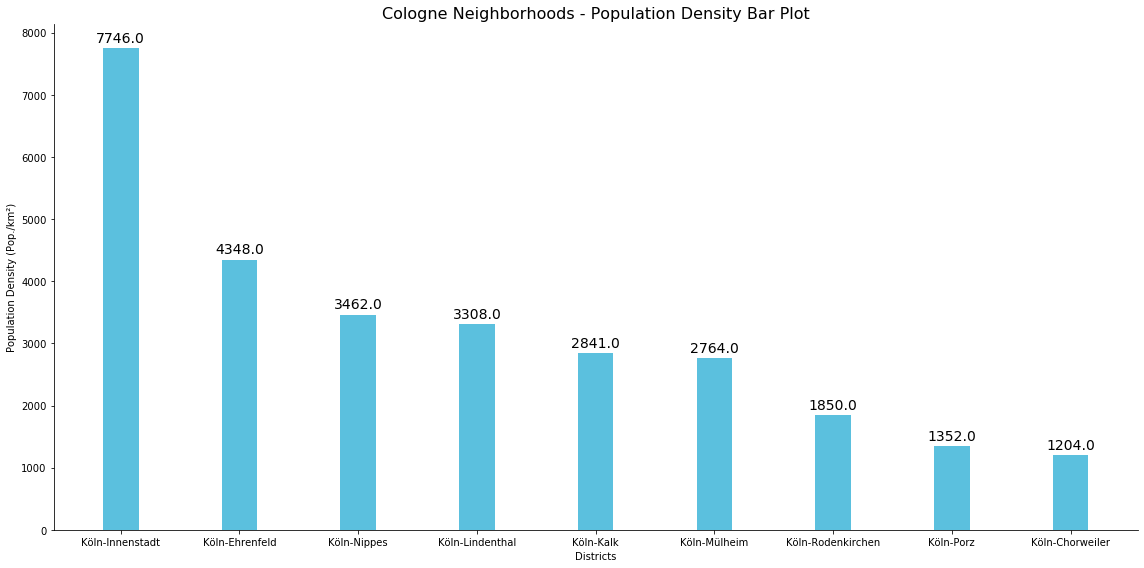

In [3]:
labels = ['Köln-Innenstadt','Köln-Ehrenfeld','Köln-Nippes','Köln-Lindenthal','Köln-Kalk','Köln-Mülheim','Köln-Rodenkirchen','Köln-Porz','Köln-Chorweiler']

ind = np.arange(len(cgn_df['Pop_Density']))  
width = 0.3

fig, ax = plt.subplots(figsize=(16,8))
rects = ax.bar(ind, cgn_df['Pop_Density'], width, label=labels, color='#5bc0de')
ax.set_title("Cologne Neighborhoods - Population Density Bar Plot", fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels((labels))
plt.ylabel('Population Density (Pop./km²)')
plt.xlabel('Districts')
ax.get_yaxis().set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)



def autolabel(rects, xpos='center'):

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height().round(2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom', fontsize=14)
        
autolabel(rects, "center")

fig.tight_layout()

plt.show()

As shown on the cleaned dataframe, only 4 districts have more than 3000 people per squared kilometer, therefore all data not falling in the criteria needs to be dropped:

In [4]:
cgn_df.drop(cgn_df.index[4:], axis=0, inplace=True)
cgn_df

,District,Area,Population,Pop_Density
0,Köln-Innenstadt,16.4 km²,127.033,7746.0
3,Köln-Ehrenfeld,23.8 km²,103.621,4348.0
4,Köln-Nippes,31.8 km²,110.092,3462.0
2,Köln-Lindenthal,41.6 km²,137.552,3308.0


#### 2.3 Getting Districts' Coordinates

In [5]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [6]:
geolocator = Nominatim(user_agent="Cologne Explorer")
cgn_df['Districts_Coord'] = cgn_df['District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
cgn_df[['Latitude', 'Longitude']] = cgn_df['Districts_Coord'].apply(pd.Series)
cgn_df.drop(['Districts_Coord'], axis=1, inplace=True)
cgn_df

,District,Area,Population,Pop_Density,Latitude,Longitude
0,Köln-Innenstadt,16.4 km²,127.033,7746.0,50.937328,6.959234
3,Köln-Ehrenfeld,23.8 km²,103.621,4348.0,50.951502,6.916529
4,Köln-Nippes,31.8 km²,110.092,3462.0,50.958994,6.941777
2,Köln-Lindenthal,41.6 km²,137.552,3308.0,50.935935,6.871246


#### 2.4 Getting Rent prices data and cleaning

Then, I've gathered data on the rent prices per squared meter for every district through official reports published on www.koeln.de

In [7]:
rent_df = pd.read_html('https://www.koeln.de/immobilien/mietspiegel.html')[0]
rent_df.drop(['3. Quartal 2018','Veränderung'], axis=1, inplace=True)
rent_df.rename(columns={'Stadtteil':'District','4. Quartal 2018/04':'Price_m2_2018'}, inplace=True)
rent_df.head()

,District,Price_m2_2018
0,Altstadt-Nord,"10,70 €"
1,Altstadt-Süd,"12,20 €"
2,Auweiler,"8,60 €"
3,Bayenthal,"11,90 €"
4,Bickendorf,"10,40 €"


After that, I've also formatted and sorted the resulting dataframe accordingly

In [19]:
neigh_list = ['Innenstadt','Ehrenfeld','Nippes','Lindenthal']
rent_array = rent_df[rent_df.District.isin(neigh_list)]
rent_df2 = pd.DataFrame(rent_array, columns=['District','Price_m2_2018'])
rent_df2['Price_m2_2018'] = rent_df2['Price_m2_2018'].str.replace('€','').str.replace(',','.').astype(float)
rent_df2.sort_values('Price_m2_2018', inplace=True, ascending=False)
rent_df2

,District,Price_m2_2018
39,Lindenthal,12.3
16,Ehrenfeld,12.1
55,Nippes,11.9


In [20]:
# No term "Innestadt" found on rent_df, therefore district was missing on rent_df2. Being the Innenstadt district mainly composed of the Altstadt-Süd und Altstadt-Nord, it was taken the average of both to be appended into the new dataframe
innenstadt = pd.DataFrame({'District':['Innenstadt'],'Price_m2_2018':[rent_df.iloc[0:2]['Price_m2_2018'].str.replace('€','').str.replace(',','.').astype(float).mean().round(1)]}, columns=['District','Price_m2_2018'])
rent_df2 = rent_df2.append(innenstadt)
rent_df2.sort_values('Price_m2_2018', inplace=True, ascending=False)
rent_df2['District'].replace({'Innenstadt':'Köln-Innenstadt','Rodenkirchen':'Köln-Rodenkirchen','Lindenthal':'Köln-Lindenthal','Ehrenfeld':'Köln-Ehrenfeld','Nippes':'Köln-Nippes','Chorweiler':'Köln-Chorweiler','Porz':'Köln-Porz','Kalk':'Köln-Kalk','Mülheim':'Köln-Mülheim'}, inplace=True)
rent_df2

,District,Price_m2_2018
39,Köln-Lindenthal,12.3
16,Köln-Ehrenfeld,12.1
55,Köln-Nippes,11.9
0,Köln-Innenstadt,11.4


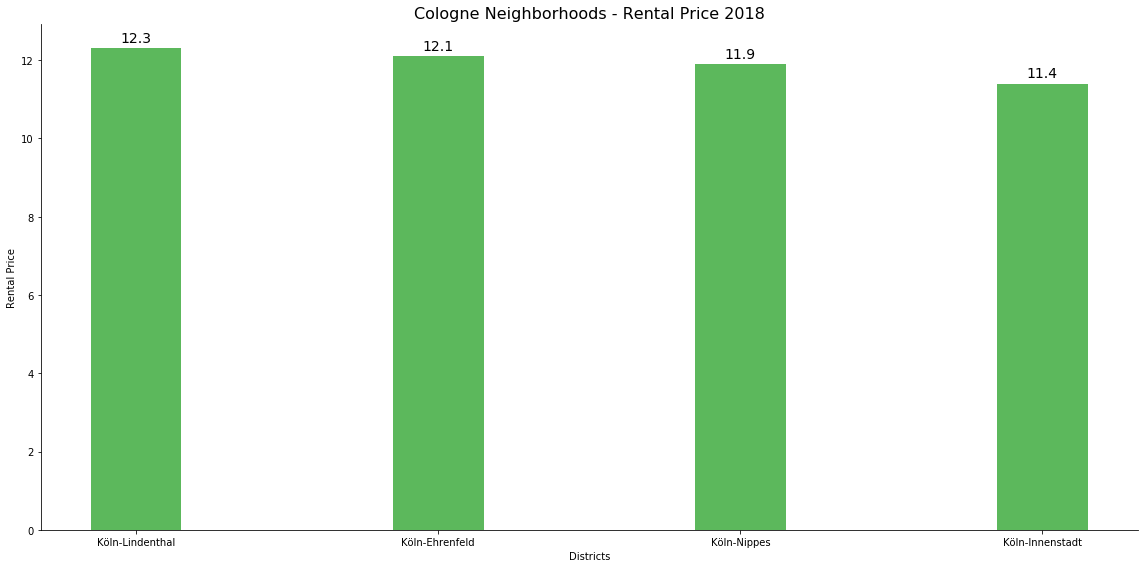

In [21]:
labels = ['Köln-Lindenthal', 'Köln-Ehrenfeld', 'Köln-Nippes', 'Köln-Innenstadt']

ind = np.arange(len(rent_df2['Price_m2_2018']))  
width = 0.3

fig, ax = plt.subplots(figsize=(16,8))
rects = ax.bar(ind, rent_df2['Price_m2_2018'], width, label=labels, color='#5cb85c')
ax.set_title("Cologne Neighborhoods - Rental Price 2018", fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels((labels))
plt.ylabel('Rental Price')
plt.xlabel('Districts')
ax.get_yaxis().set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

autolabel(rects, "center")

fig.tight_layout()

plt.show()

According to the resulting dataframe, two districts had already a rent price of more than 12€ per squared meter. We will hence drop the respective rows in the main dataframe:

In [22]:
cgn_df.drop([cgn_df.index[1],cgn_df.index[3]], axis=0, inplace=True)
cgn_df

,District,Area,Population,Pop_Density,Latitude,Longitude
0,Köln-Innenstadt,16.4 km²,127.033,7746.0,50.937328,6.959234
4,Köln-Nippes,31.8 km²,110.092,3462.0,50.958994,6.941777


#### 2.5 Getting Venues Data through Foursquare API

In [23]:
CLIENT_ID = '2QLU5CN20BM5KPMDHX2QYYBWG13KZAYXAYOIQX0S0300KW01' # your Foursquare ID
CLIENT_SECRET = 'RND2YVJCGI10NSERVO4LCVGFYETQUROC3OCBD0MMK1XPFKKA' # your Foursquare Secret
VERSION = '20200429'
LIMIT = 200
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 2QLU5CN20BM5KPMDHX2QYYBWG13KZAYXAYOIQX0S0300KW01
CLIENT_SECRET:RND2YVJCGI10NSERVO4LCVGFYETQUROC3OCBD0MMK1XPFKKA


In [25]:
query_1 = 'Bar'
query_2 = 'Restaurant'
radius = 1250
print('Queries OK!')

Queries OK!


In [26]:
url_inne1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, cgn_df.iloc[0][4], cgn_df.iloc[0][5], VERSION, query_1, radius, LIMIT)
url_nipp1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, cgn_df.iloc[1][4], cgn_df.iloc[1][5], VERSION, query_1, radius, LIMIT)

url_inne2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, cgn_df.iloc[0][4], cgn_df.iloc[0][5], VERSION, query_2, radius, LIMIT)
url_nipp2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, cgn_df.iloc[1][4], cgn_df.iloc[1][5], VERSION, query_2, radius, LIMIT)


print("URLs created!")

URLs created!


In [31]:
results_inne1 = requests.get(url_inne1).json()
results_nipp1 = requests.get(url_nipp1).json()

results_inne2 = requests.get(url_inne2).json()
results_nipp2 = requests.get(url_nipp2).json()

print("GET Request done, results generated")

GET Request done, results generated


In [32]:
venues_inne1 = results_inne1['response']['venues']
venues_nipp1 = results_nipp1['response']['venues']

venues_inne2 = results_inne2['response']['venues']
venues_nipp2 = results_nipp2['response']['venues']

print("JSON File sorted out")

JSON File sorted out


In [33]:
df_inne1 = pd.json_normalize(venues_inne1)
df_inne1['District'] = 'Köln-Innenstadt'
df_inne1['Category'] = 'Bar'
df_inne1.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,...,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id,location.neighborhood,District,Category
0,5be9e3abbed483002defeae0,Piano Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1589827251,False,Heumarkt 20,50.935221,6.962502,"[{'label': 'display', 'lat': 50.935221, 'lng':...",328,...,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Heumarkt 20, 50667 Köln, Deutschland]",NaN,NaN,NaN,Köln-Innenstadt,Bar
1,4b05886bf964a520bbc422e3,Legends Bar,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",v-1589827251,False,Kennedy-Ufer 2a,50.940640,6.968993,"[{'label': 'display', 'lat': 50.94063998180731...",777,...,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Kennedy-Ufer 2a, 50679 Köln, Deutschland]",NaN,NaN,NaN,Köln-Innenstadt,Bar
2,4bd86918e914a593e12453fa,Savoca Bar + Café,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1589827251,False,Breite Str. 2-26,50.939072,6.953066,"[{'label': 'display', 'lat': 50.93907188405377...",474,...,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Breite Str. 2-26, 50667 Köln, Deutschland]",NaN,NaN,NaN,Köln-Innenstadt,Bar
3,4b058870f964a5200fc622e3,Piano Bar,"[{'id': '4bf58dd8d48988d1e8931735', 'name': 'P...",v-1589827251,False,Trankgasse 1-5,50.941965,6.956604,"[{'label': 'display', 'lat': 50.94196488579533...",548,...,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Trankgasse 1-5, 50667 Köln, Deutschland]",NaN,NaN,NaN,Köln-Innenstadt,Bar
4,4c6fa992d274b60c683cd70d,Caffé Bar Alfredo,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1589827251,False,Breite Str. 80-90,50.938974,6.948486,"[{'label': 'display', 'lat': 50.93897391628048...",775,...,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Breite Str. 80-90, 50667 Köln, Deutschland]",NaN,NaN,NaN,Köln-Innenstadt,Bar


In [34]:
df_nipp1 = json_normalize(venues_nipp1)
df_nipp1['District'] = 'Köln-Nippes'
df_nipp1['Category'] = 'Bar'

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [35]:
df_inne2 = json_normalize(venues_inne2)
df_inne2['District'] = 'Köln-Innenstadt'
df_inne2['Category'] = 'Restaurant'

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [36]:
df_nipp2 = json_normalize(venues_nipp2)
df_nipp2['District'] = 'Köln-Nippes'
df_nipp2['Category'] = 'Restaurant'

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [37]:
df_merged = pd.concat([df_inne1, df_inne2, df_nipp1, df_nipp2])
df_clean = df_merged[['name','Category','District','location.address','location.postalCode','location.lat','location.lng','location.distance']]
df_clean.rename({'name':'Venue','location.address':'Address','location.postalCode':'PostalCode','location.lat':'LocationLatitude','location.lng':'LocationLongitude','location.distance':'LocationDistance'}, axis=1, inplace=True)
df_clean.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Venue,Category,District,Address,PostalCode,LocationLatitude,LocationLongitude,LocationDistance
0,Piano Bar,Bar,Köln-Innenstadt,Heumarkt 20,50667,50.935221,6.962502,328
1,Legends Bar,Bar,Köln-Innenstadt,Kennedy-Ufer 2a,50679,50.940640,6.968993,777
2,Savoca Bar + Café,Bar,Köln-Innenstadt,Breite Str. 2-26,50667,50.939072,6.953066,474
3,Piano Bar,Bar,Köln-Innenstadt,Trankgasse 1-5,50667,50.941965,6.956604,548
4,Caffé Bar Alfredo,Bar,Köln-Innenstadt,Breite Str. 80-90,50667,50.938974,6.948486,775


In [38]:
# create a Stamen Toner map of the world centered around Cologne, Germany
cologne_map = folium.Map(location=[50.936631, 6.958401], zoom_start=10)

# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, dist in zip(df_clean.LocationLatitude, df_clean.LocationLongitude, df_clean.District):
    if dist == 'Köln-Innenstadt':
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6))
    
    elif dist == 'Köln-Nippes':
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6))    

    else:
           pass
            
cologne_map.add_child(locations)

In [39]:
nipp_df = pd.concat([df_nipp1, df_nipp2])
nipp_df = nipp_df[['name','Category','District','location.address','location.postalCode','location.lat','location.lng','location.distance']]
nipp_df.rename({'name':'Venue','location.address':'Address','location.postalCode':'PostalCode','location.lat':'LocationLatitude','location.lng':'LocationLongitude','location.distance':'LocationDistance'}, axis=1, inplace=True)

nipp_df.head()

,Venue,Category,District,Address,PostalCode,LocationLatitude,LocationLongitude,LocationDistance
0,Stern Hagel Bar,Bar,Köln-Nippes,Krefelder Str. 101,50670,50.953816,6.950430,836
1,[cafe bar] (cafe bar),Bar,Köln-Nippes,Neusser Str. 28,50670,50.952492,6.957143,1298
2,NH Collection Bar,Bar,Köln-Nippes,Im Mediapark 9,50670,50.949020,6.948658,1210
3,Red Lounge/Bar,Bar,Köln-Nippes,Hansaring 97,50670‎,50.948843,6.951611,1323
4,Bar centrale,Bar,Köln-Nippes,Viersener Str. 16,50733,50.963603,6.951535,855


In [40]:
nipp_df['Category'].value_counts()

Bar           17
Restaurant     6
Name: Category, dtype: int64

In [42]:
inne_df = pd.concat([df_inne1, df_inne2])
inne_df = inne_df[['name','Category','District','location.address','location.postalCode','location.lat','location.lng','location.distance']]
inne_df.rename({'name':'Venue','location.address':'Address','location.postalCode':'PostalCode','location.lat':'LocationLatitude','location.lng':'LocationLongitude','location.distance':'LocationDistance'}, axis=1, inplace=True)

inne_df.head()

,Venue,Category,District,Address,PostalCode,LocationLatitude,LocationLongitude,LocationDistance
0,Piano Bar,Bar,Köln-Innenstadt,Heumarkt 20,50667,50.935221,6.962502,328
1,Legends Bar,Bar,Köln-Innenstadt,Kennedy-Ufer 2a,50679,50.940640,6.968993,777
2,Savoca Bar + Café,Bar,Köln-Innenstadt,Breite Str. 2-26,50667,50.939072,6.953066,474
3,Piano Bar,Bar,Köln-Innenstadt,Trankgasse 1-5,50667,50.941965,6.956604,548
4,Caffé Bar Alfredo,Bar,Köln-Innenstadt,Breite Str. 80-90,50667,50.938974,6.948486,775


In [43]:
inne_df['Category'].value_counts()

Restaurant    50
Bar           50
Name: Category, dtype: int64

In [46]:
neigh_data = {'Bar': [50,17],
        'Restaurant': [50,6]
        }

comp_df = pd.DataFrame(neigh_data, columns = ['Bar','Restaurant'], index=['Köln-Innenstadt','Köln-Nippes'])
comp_df

,Bar,Restaurant
Köln-Innenstadt,50,50
Köln-Nippes,17,6


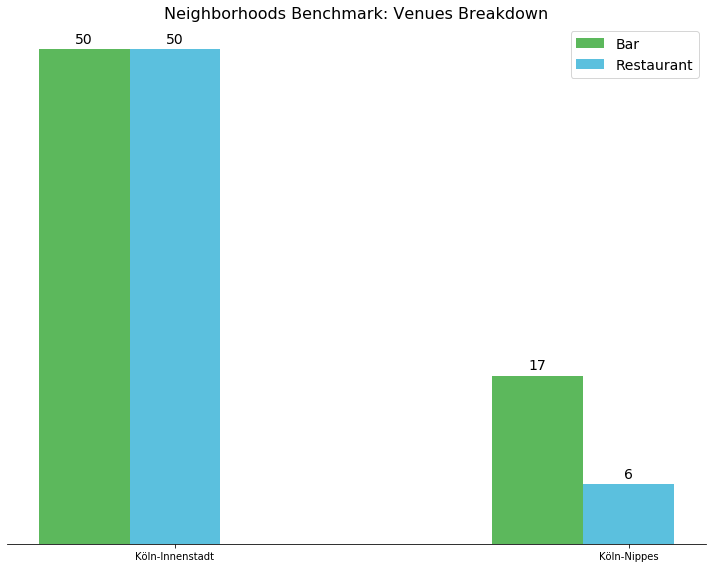

In [62]:
labels =['Köln-Innenstadt','Köln-Nippes']
bar = comp_df['Bar']
restaurant = comp_df['Restaurant']


ind = np.arange(len(bar))  
width = 0.2

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(ind - width, bar, width, label='Bar', color='#5cb85c')
rects2 = ax.bar(ind, restaurant, width, label='Restaurant', color='#5bc0de')


ax.set_title("Neighborhoods Benchmark: Venues Breakdown", fontsize=16)
ax.set_xticks(ind)
plt.ylabel('Number of Venues')
ax.set_xticklabels((labels))
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14)

autolabel(rects1, "center")
autolabel(rects2, "center")


fig.tight_layout()

plt.show()

In [25]:
X = df_clean[['LocationLatitude','LocationLongitude']].values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

In [26]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=6)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 2 1 4 4 1 0 4 0 4 0 0 1 4 1 0 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 1 1
 4 0 1 4 1 0 0 0 0 0 0 0 0 1 1 1 4 4 1 0 4 2 2 1 1 2 1 2 1 0 0 0 1 1 1 1 1
 1 0 1 2 1 0 2 4 4 4 0 1 0 0 0 0 1 1 4 4 0 0 1 1 4 1 4 4 4 1 4 4 3 4 4 0 4
 0 1 0 0 4 4 0 3 0 0 4 4]


In [150]:
df_clean["ClusterLabels"] = labels
df_clean.head(5)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Venue,Category,District,Address,PostalCode,LocationLatitude,LocationLongitude,LocationDistance,ClusterLabels
0,Piano Bar,Bar,Köln-Innenstadt,Heumarkt 20,50667,50.935221,6.962502,328,0
1,Legends Bar,Bar,Köln-Innenstadt,Kennedy-Ufer 2a,50679,50.940640,6.968993,777,0
2,Savoca Bar + Café,Bar,Köln-Innenstadt,Breite Str. 2-26,50667,50.939072,6.953066,474,0
3,Piano Bar,Bar,Köln-Innenstadt,Trankgasse 1-5,50667,50.941965,6.956604,548,0
4,Bar 48,Bar,Köln-Innenstadt,Cäcilienstr. 48,50667,50.935545,6.949746,694,3


In [ ]:
# create a Stamen Toner map of the world centered around Cologne, Germany
cologne_map = folium.Map(location=[50.936631, 6.958401], zoom_start=10)

# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, label in zip(df_clean.LocationLatitude, df_clean.LocationLongitude, df_clean.ClusterLabels):
    if label == 0:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6))
    elif label == 1:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6))
    elif label == 2:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6))
    elif label == 3:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.6))
    elif label == 4:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='orange',
            fill=True,
            fill_color='orange',
            fill_opacity=0.6))
    elif label == 5:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='pink',
            fill=True,
            fill_color='pink',
            fill_opacity=0.6))
    elif label == 6:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.6))
    elif label == 7:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='brown',
            fill=True,
            fill_color='brown',
            fill_opacity=0.6))
    elif label == 8:
        locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='violet',
            fill=True,
            fill_color='violet',
            fill_opacity=0.6))
        

    else:
           pass
            
cologne_map.add_child(locations)

In [152]:
clust_df = round(df_clean.sort_values('ClusterLabels'),2)
clust_df.head()

,Venue,Category,District,Address,PostalCode,LocationLatitude,LocationLongitude,LocationDistance,ClusterLabels
0,Piano Bar,Bar,Köln-Innenstadt,Heumarkt 20,50667,50.94,6.96,328,0
12,Ilios Restaurant,Restaurant,Köln-Innenstadt,Dreikönigenstr. 54,50678,50.93,6.97,1401,0
11,Restaurant OASIS,Restaurant,Köln-Innenstadt,Kennedy-Ufer 1,50679,50.94,6.97,688,0
10,Restaurant Heumarkt,Restaurant,Köln-Innenstadt,Heumarkt 47,50667,50.94,6.96,138,0
9,Restaurant Einstein,Restaurant,Köln-Innenstadt,Halle 2.2,50679,50.94,6.98,1402,0
